In [137]:
from gammapy.estimators import LightCurve
from scipy.signal import lombscargle, periodogram
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import astropy.units as u

/opt/homebrew/Caskroom/miniconda/base/envs/gammapy-dev/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


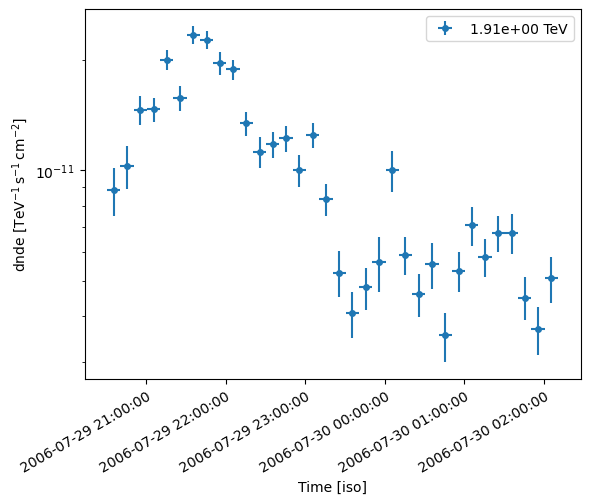

In [138]:
#Read the lightcurve from PKS2155
lc = LightCurve.read("$GAMMAPY_DATA/estimators/pks2155_hess_lc/pks2155_hess_lc.fits")
lc.plot()
plt.show()

In [139]:
#Define quantities for convenience
time = lc.geom.axes["time"]
data = lc.norm.data.flatten()
err = lc.norm_err.data.flatten()

In [140]:
#Extract frequencies and power spectrum (periodogram) by Fourier transform of the time bin sampling
fixed_frequencies  = np.fft.fftfreq(time.nbin, d=0.162)
power = np.abs(np.fft.fft(data)[fixed_frequencies>=0])**2

In [141]:
#Periodogram from scipy
freqs, pxx = periodogram(data, fs=1/0.162)
coefficients = np.polyfit(np.log(freqs[freqs != 0]), np.log(pxx[freqs != 0]), 1)
poly = np.poly1d(coefficients)

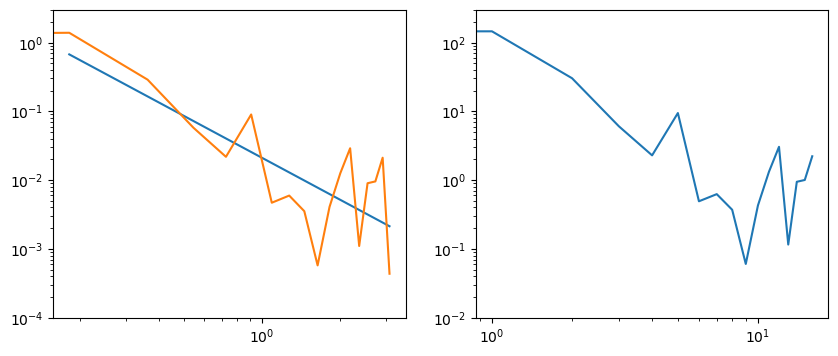

In [142]:
#Comparison of simple periodograms "by hand" and from scipy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].loglog(freqs[freqs != 0], np.exp(poly(np.log(freqs[freqs != 0]))))
axs[0].loglog(freqs, pxx)
axs[0].set_ylim(1e-4, 3e0)
axs[1].loglog(power)
axs[1].set_ylim(1e-2, 3e2)
plt.show()

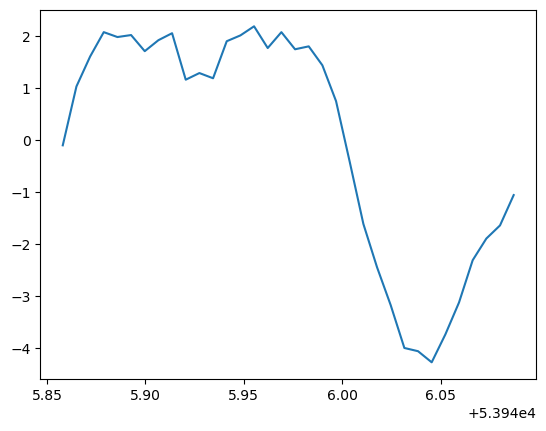

In [143]:
#Timmers simulation of the lightcurve from the periodogram

exponent = np.abs(coefficients[0])
num_points = len(fixed_frequencies)
power_law_spectrum = power
random_numbers = np.random.normal(0, 1, len(power_law_spectrum) - 1) + 1j * np.random.normal(0, 1, len(power_law_spectrum) - 1)
fourier_coeffs = np.sqrt(0.5 * power_law_spectrum[:-1]) * random_numbers

# Nyquist frequency component handling
if num_points % 2 == 0:
    # For even number of data points
    fourier_coeffs = np.concatenate([fourier_coeffs, np.sqrt(0.5 * power_law_spectrum[-1]) * np.random.normal(0, 1, 1)])
else:
    # For odd number of data points
    fourier_coeffs = np.concatenate([fourier_coeffs, np.sqrt(0.5 * power_law_spectrum[-1]) * (np.random.normal(0, 1, 1)+ 1j * np.random.normal(0, 1, 1))])

# Complex conjugate for negative frequencies
fourier_coeffs = np.concatenate([fourier_coeffs, np.conjugate(fourier_coeffs[-2::-1])])
fourier_coeffs = np.insert(fourier_coeffs,0, 0)

# Inverse Fourier Transform to obtain time series
time_series = np.fft.ifft(fourier_coeffs).real

plt.plot(time.time_mid.mjd, time_series)
plt.show()

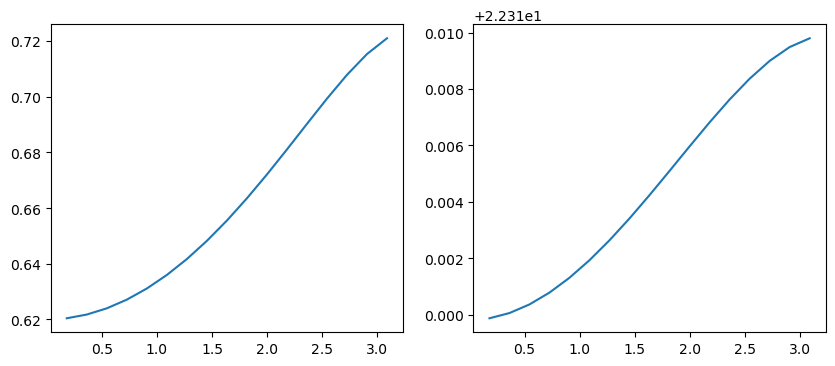

In [144]:
#Lomb-Scargle periodogram implementations in scipy and astropy. 
#The range of frequencies is selected by the simple scipy periodogram
lsc_scipy = lombscargle(time.time_mid.mjd, data,  freqs[freqs != 0])
lsc_astro = LombScargle(time.time_mid.mjd, data, err).power(freqs)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(freqs, lsc_astro)
axs[1].plot(freqs[freqs != 0],lsc_scipy)
plt.show()

In [145]:
#Pseudo-nyquist frequency for finite uneven data sampling
nyq = 1/(2*np.diff(time.time_mid.mjd))

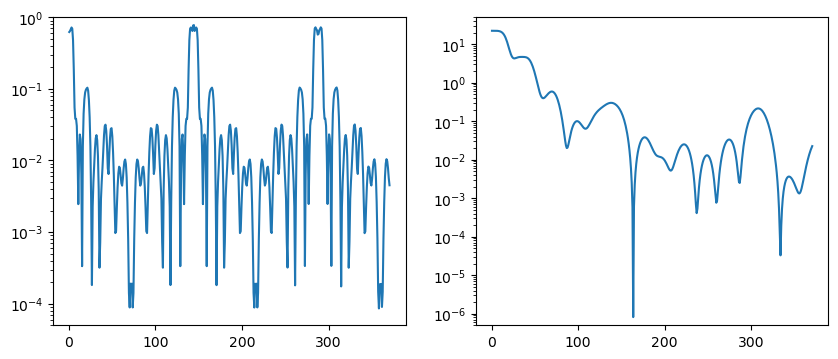

In [156]:
#Lomb-Scargle periodogram implementations in scipy and astropy. 
#The range of frequencies is selected by the astropy implementation

frequency, lspower = LombScargle(time.time_mid, data, err).autopower()
lsc2 = lombscargle(time.time_mid.mjd, data,  frequency)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].semilogy(frequency,lspower)
axs[0].set_ylim(5e-5, 1)
axs[1].semilogy(frequency, lsc2)
axs[1].set_ylim(5e-7, 50)

plt.show()

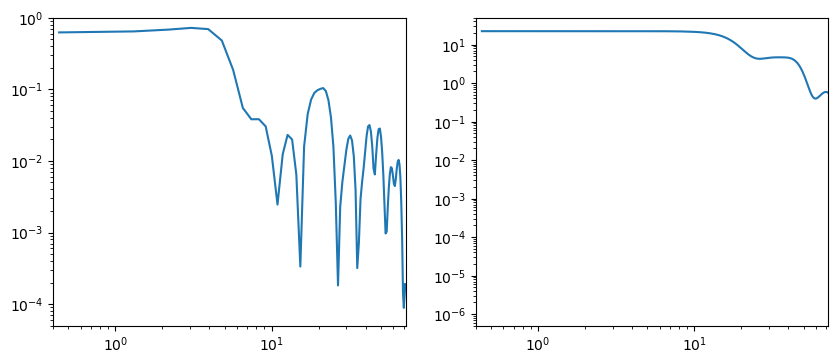

In [157]:
#Lomb-Scargle periodogram implementations in scipy and astropy. 
#The range of frequencies is selected by the astropy implementation, but cut at the pseudo-nyquist only for plotting

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].loglog(frequency, lspower)
axs[0].set_xlim(0.4, nyq[0])
axs[0].set_ylim(5e-5, 1)
axs[1].loglog(frequency, lsc2)
axs[1].set_xlim(0.4, nyq[0])
axs[1].set_ylim(5e-7, 50)
plt.show()

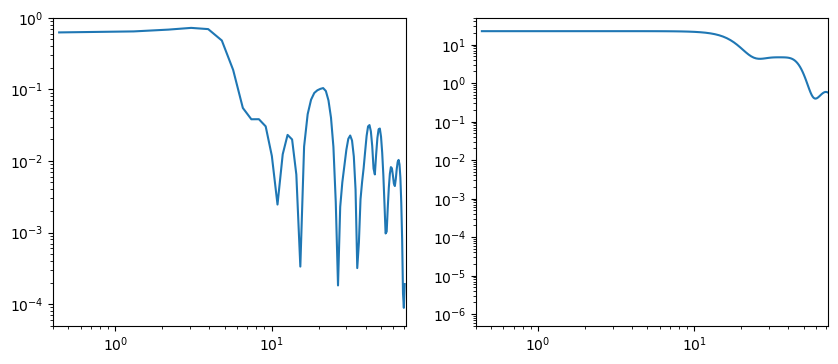

In [159]:
#Lomb-Scargle periodogram implementations in scipy and astropy. 
#The range of frequencies is selected by the astropy implementation but cut at the pseudo-nyquist at the computation level

lsc_scipy2 = lombscargle(time.time_mid.mjd, data,  frequency.value[frequency.value<=nyq[0]])
lsc_astro2 = LombScargle(time.time_mid.mjd, data, err).power(frequency.value[frequency.value<=nyq[0]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].loglog(frequency.value[frequency.value<=nyq[0]], lsc_astro2)
axs[0].set_xlim(0.4, nyq[0])
axs[0].set_ylim(5e-5, 1)

axs[1].loglog(frequency.value[frequency.value<=nyq[0]], lsc_scipy2)
axs[1].set_xlim(0.4, nyq[0])
axs[1].set_ylim(5e-7, 50)

plt.show()